# Audio Classification with Neural Networks [50 ]

<center>
    <img src="./assets/audio.jpeg">
</center>

### Introduction

I delved into the realm of audio signal processing and machine learning. I created a Neural Networks using PyTorch to perform this classification task.

I used the `AudioMNIST` dataset: tens of thousands of audio samples of people with different accents, coming from different regions of the world, speaking different digits. You can download the dataset using [this link](https://drive.google.com/file/d/1EDbjnXFlmdnru1N36KpQR054dSpsixW8/view?usp=sharing).

I used how to use MFCCs to extract features from audio and PyTorch to classify audio.

## Imports

In [1]:
import glob
import random
import os

import numpy as np
import matplotlib.pyplot as plt
# !pip install --user librosa
import librosa
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F

Extracting Mel-frequency Cepstral Coefficients (MFCCs) from audio messages, a fundamental step in audio feature extraction. MFCCs are widely used for their effectiveness in capturing the essential characteristics of audio signals, making them an ideal choice for our classification task.

The dataset consists of 60 folders, each one corresponding to a different speaker with a different accent. Each folder contains 500 audio files, with each one corresponding to a different utterance of a digit from 0 to 9.

Let's play one of them.

In [2]:
# Play audio (might have to turn your volume up!)
import IPython.display as ipd

sample_path = "data/02/0_02_0.wav"
ipd.Audio(sample_path)

How would you go about feeding data like this to *any* model?

Well first you'd have to think of a way to represent the input as features. One technique that lets us extract features from raw audio samples, is to calculate the MFCCs (as mentioned before) for each one. You can read more about them here, but the main takeaway is that you now know a technique with which to *represent* an audio sample as a **fixed-size vector of features**.

I used the `librosa` library to perform the operations.

In [34]:
data_folder = "data"
wav_paths = glob.glob(os.path.join(data_folder, "*", "*.wav"))
random.shuffle(wav_paths)

print(wav_paths)

# Testing
sample_path = wav_paths[0]
ipd.Audio(sample_path)

['data\\51\\6_51_46.wav', 'data\\04\\7_04_24.wav', 'data\\40\\8_40_11.wav', 'data\\23\\4_23_1.wav', 'data\\23\\7_23_36.wav', 'data\\17\\9_17_48.wav', 'data\\01\\7_01_17.wav', 'data\\05\\8_05_22.wav', 'data\\53\\6_53_25.wav', 'data\\34\\8_34_40.wav', 'data\\26\\9_26_6.wav', 'data\\04\\6_04_2.wav', 'data\\24\\8_24_34.wav', 'data\\35\\3_35_19.wav', 'data\\17\\3_17_25.wav', 'data\\04\\9_04_3.wav', 'data\\44\\5_44_12.wav', 'data\\14\\6_14_35.wav', 'data\\31\\4_31_46.wav', 'data\\33\\5_33_34.wav', 'data\\31\\3_31_11.wav', 'data\\58\\0_58_39.wav', 'data\\51\\6_51_33.wav', 'data\\51\\4_51_29.wav', 'data\\04\\7_04_45.wav', 'data\\23\\0_23_39.wav', 'data\\26\\0_26_1.wav', 'data\\20\\8_20_11.wav', 'data\\29\\7_29_49.wav', 'data\\11\\3_11_3.wav', 'data\\12\\2_12_28.wav', 'data\\14\\8_14_22.wav', 'data\\22\\1_22_47.wav', 'data\\35\\6_35_46.wav', 'data\\59\\7_59_15.wav', 'data\\06\\1_06_17.wav', 'data\\03\\9_03_33.wav', 'data\\57\\1_57_16.wav', 'data\\42\\3_42_27.wav', 'data\\59\\8_59_14.wav', 'data

In [35]:


fnames = 'data'
for i, fpath in enumerate(fnames):
    print(i,fpath)

0 d
1 a
2 t
3 a


In [3]:
## Create the dataset

def generate_features(fpath):
    '''
    Generate 40 MFCC features from the argument audio file as input to the model
    '''
    print("generate feature k andar:",fpath)
    # TODO: Load in the file using librosa
    signal, sr = librosa.load(fpath)

    # TODO: Trim the audio file
    trimmed_signal, index = librosa.effects.trim(signal)

    # TODO: Generate the MFCCs
    mfcc = librosa.feature.mfcc(y=trimmed_signal, n_mfcc=40, sr=sr)

    # TODO: Generate the features
    # Taking the mean of the transpose MFCCs along axis=0
    mfcc_transpose = mfcc.T
    mfccs_processed = mfcc_transpose.mean(axis=0)
    return mfccs_processed

def get_label(fpath):
    '''
    Get the label from the filepath
    Example:
    1_23_4.wav -> 1
    '''
    # TODO: get the label

    return int(os.path.basename(fpath)[0])

def create_dataset(fnames):
    '''
    Create the dataset, i.e. features and labels, from the list of filepaths
    '''
    features = []
    labels = []
    
    for i, fpath in enumerate(fnames):
        if i % (len(fnames) // 10) == 0 or i == len(fnames)-1:
            print(f'Processing {i} of {len(fnames)} files')
        # TODO: Generate the features and label, appending to the lists
        features.append(generate_features(fpath))
        labels.append(get_label(fpath))
    
    return features, labels
    
# Create the dataset using the function above
# This could take a while, so consider saving some .npy files (if you wish to continue later)
features, labels = create_dataset(wav_paths)

np.save('features.npy', np.asarray(features))
np.save('labels.npy', np.asarray(labels))

X, y = np.load('features.npy'), np.load('labels.npy')
# print("features:",X)
# print("labels:",y)
print(X.shape, y.shape)

(30000, 40) (30000,)


In [4]:
# Convert to tensors
X = torch.tensor(X)
y = torch.tensor(y)

# TODO: Create a train-test split (stratify using the labels)
X_train, X_test, y_train, y_test = X[0:21000], X[21000:], y[0:21000], y[21000:]
y_train = y_train.long()
y_test = y_test.long()

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
# print("X_train:",X_train)
# print("y_train",y_train)
# print("X_test",X_test)
# print("y_test",y_test)

torch.Size([21000, 40]) torch.Size([21000]) torch.Size([9000, 40]) torch.Size([9000])


## Creating and Training an Audio Classifier

<center>
    <img src="./assets/neural-networks.jpg">
</center>

Using PyTorch to create a Neural Network that can classify the audio samples. It can be helpful to go through the following chapter before you start: [PyTorch Classification by learnpytorch.io](https://www.learnpytorch.io/02_pytorch_classification/).

When creating the model, be mindful of the following points:
- You must make use of `torch.nn` when creating your model.

- The input size of the model should be the same as the size of the feature vectors.

- The output size of the model should be 10, since there are 10 classes. Note that this also implies you should be using the Cross Entropy Loss function (which is `nn.CrossEntropyLoss` in PyTorch).

- *You can make any sized model you want, but note that smaller architectures train faster and work well for this task.*

- There must be non-linear activation functions between the layers: try `nn.ReLU` or `nn.Tanh`.

In [5]:
## TODO: Create an AudioClassifier class (10 )
class AudioClassifier(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, hidden_size3, output_size):
        super(AudioClassifier, self).__init__()
        self.hidden_layer_1 = nn.Linear(input_size, hidden_size1)
        self.relu1 = nn.ReLU()
        self.hidden_layer_2 = nn.Linear(hidden_size1, hidden_size2)
        self.relu2 = nn.ReLU()
        self.hidden_layer_3 = nn.Linear(hidden_size2, hidden_size3)
        self.relu3 = nn.ReLU()
        self.output_layer = nn.Linear(hidden_size3, output_size)

    def forward(self, x):
        x = self.hidden_layer_1(x)
        x = self.relu1(x)
        x = self.hidden_layer_2(x)
        x = self.relu2(x)
        x = self.hidden_layer_3(x)
        x = self.relu3(x)
        x = self.output_layer(x)
        return x

input_size = 40
hidden_size1 = 100
hidden_size2 = 70
hidden_size3 = 80
output_size = 10

# TODO: Instantiate the model
model = AudioClassifier(input_size, hidden_size1, hidden_size2, hidden_size3, output_size)
print(model)

# TODO: Create the loss function
loss_fn = nn.CrossEntropyLoss()

# TODO: Create the optimizer (use Adam)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

AudioClassifier(
  (hidden_layer_1): Linear(in_features=40, out_features=100, bias=True)
  (relu1): ReLU()
  (hidden_layer_2): Linear(in_features=100, out_features=70, bias=True)
  (relu2): ReLU()
  (hidden_layer_3): Linear(in_features=70, out_features=80, bias=True)
  (relu3): ReLU()
  (output_layer): Linear(in_features=80, out_features=10, bias=True)
)


The last step is to create **training and evaluation** loops for our model.


In [6]:
## Write functions to train and evaluate the model (10+10+5 )

def fit_one_epoch(model,
                  X, y,
                  optimizer, loss_fn):
    '''
    Perform one epoch of training
    '''
    # Set the model in train mode
    model.train()
    
    # TODO: Forward Pass (get the logits)
    logits = model(X)

    # TODO: Calculate the loss
    loss = loss_fn(logits, y)

    # TODO: Optimizer zero grad
    optimizer.zero_grad()

    # TODO: Backward pass
    loss.backward()

    # TODO: Step the optimizer
    optimizer.step()

    # Calculate the accuracy
    # Hint: Take the argmax of the logits along the last axis and compare with y
    acc = (logits.argmax(dim=1) == y).float().mean()

    return loss.item(), acc.item()

@torch.no_grad()
def evaluate(model,
             X, y,
             loss_fn):
    '''
    Perform one epoch of evaluation
    '''
    # Set the model in eval mode
    model.eval()

    # TODO: Forward Pass (get the logits)
    logits = model(X)

    # TODO: Calculate the loss
    loss = loss_fn(logits, y)

    # TODO: Calculate the accuracy
    acc = (logits.argmax(dim=1) == y).float().mean()

    return loss.item(), acc.item()

def fit(model,
        X_train, y_train, X_val, y_val,
        optimizer, loss_fn,
        epochs=200):
    '''
    Perform the entire training process
    '''

    # Create a history object to store the losses and accuracies
    history = {k: [] for k in ["train_loss", "train_acc", "val_loss", "val_acc"]}
    
    for epoch in range(epochs):
        # TODO: Training step
        train_loss, train_acc = fit_one_epoch(model, X_train, y_train, optimizer, loss_fn)
        
        # TODO: Evaluation step
        val_loss, val_acc = evaluate(model, X_val, y_val, loss_fn)
        
        # Optional logging
        if epoch % (epochs//10) == 0 or epoch == epochs-1:
            print(f"Epoch {epoch} | Train loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | Val loss: {val_loss:.4f} | Val acc: {val_acc:.4f}")

        # Save the losses and accuracies to the history object    
        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)
    
    return history

In [7]:
# Fit the model and plot the losses
history = fit(model, X_train, y_train, X_test, y_test, optimizer, loss_fn, epochs=800)

# Save the model
torch.save(model.state_dict(), 'audio_classifier.pth')

Epoch 0 | Train loss: 5.9578 | Train Acc: 0.1297 | Val loss: 8.4690 | Val acc: 0.0959
Epoch 80 | Train loss: 0.4382 | Train Acc: 0.8367 | Val loss: 0.4561 | Val acc: 0.8288
Epoch 160 | Train loss: 0.2398 | Train Acc: 0.9135 | Val loss: 0.2494 | Val acc: 0.9104
Epoch 240 | Train loss: 0.1741 | Train Acc: 0.9390 | Val loss: 0.2004 | Val acc: 0.9277
Epoch 320 | Train loss: 0.1419 | Train Acc: 0.9513 | Val loss: 0.1799 | Val acc: 0.9371
Epoch 400 | Train loss: 0.3554 | Train Acc: 0.8812 | Val loss: 0.3440 | Val acc: 0.8848
Epoch 480 | Train loss: 0.1151 | Train Acc: 0.9609 | Val loss: 0.1645 | Val acc: 0.9437
Epoch 560 | Train loss: 0.0977 | Train Acc: 0.9668 | Val loss: 0.1625 | Val acc: 0.9461
Epoch 640 | Train loss: 0.0844 | Train Acc: 0.9716 | Val loss: 0.1670 | Val acc: 0.9457
Epoch 720 | Train loss: 0.0752 | Train Acc: 0.9755 | Val loss: 0.1749 | Val acc: 0.9444
Epoch 799 | Train loss: 0.1482 | Train Acc: 0.9466 | Val loss: 0.2318 | Val acc: 0.9323


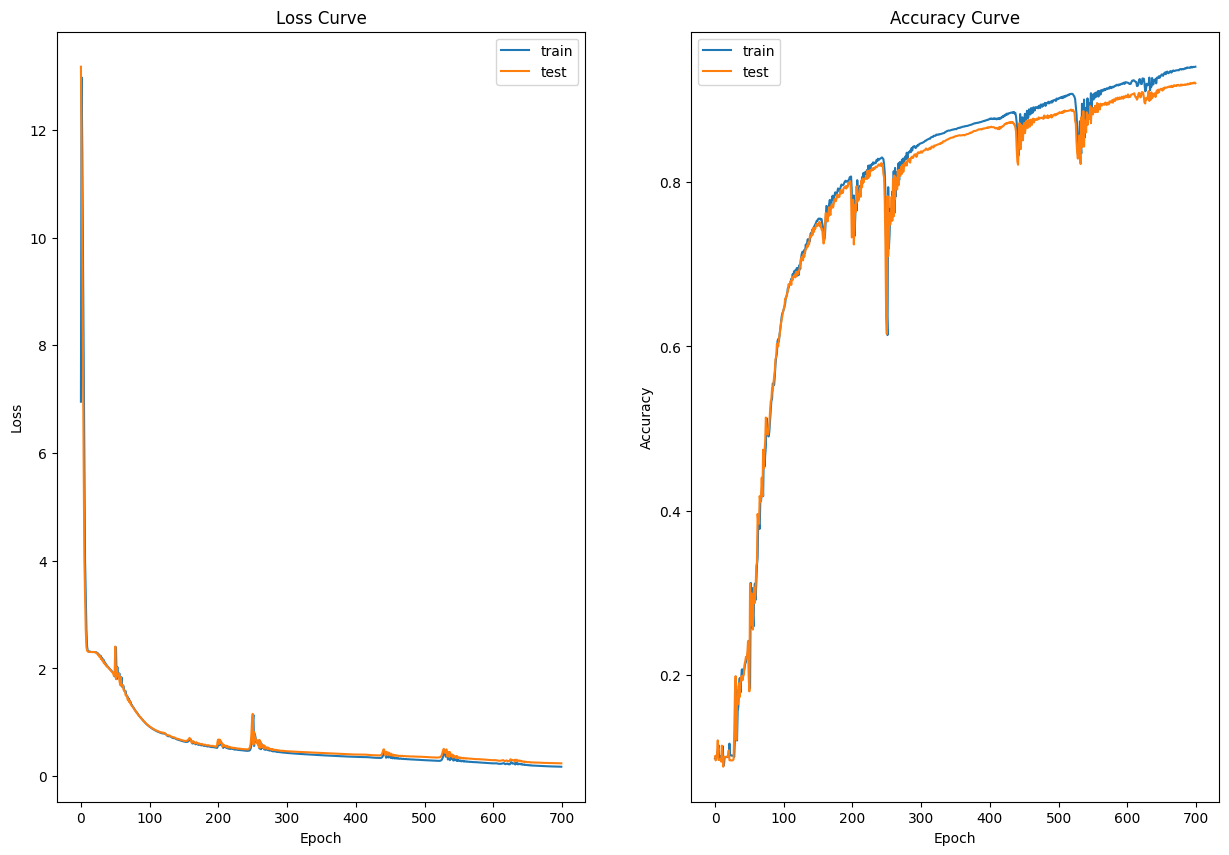

In [41]:
# Plot the loss curves
plt.figure(figsize=(15, 10))

plt.subplot(121)
plt.plot(history['train_loss'], label='train')
plt.plot(history['val_loss'], label='test')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title("Loss Curve")
plt.legend()

plt.subplot(122)
plt.plot(history['train_acc'], label='train')
plt.plot(history['val_acc'], label='test')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title("Accuracy Curve")
plt.legend()

plt.show()

### Inference on Custom Sample
Using the model to make predictions on custom audio samples. 

*Note that you must apply the same preprocessing steps for feature extraction as before, since your model only knows and is configured to work for that.*

In [138]:
@torch.no_grad()
def predict(fpth, model):
    '''
    Performs end-to-end inference on a sample audio file.
    '''
    
    # TODO: Prepare features
    print("mypath:",fpth)
    features = generate_features(fpth)
    labels = get_label(fpth)

    np.save('features_pred.npy', np.asarray(features))
    np.save('labels_pred.npy', np.asarray(labels))

    X, y = np.load('features_pred.npy'), np.load('labels_pred.npy')
    # print(X.shape, y.shape)

    X = torch.tensor(X)
    y = torch.tensor(y).long()
    print("X",X)
    print("y",y)

    print("X_type",type(X))
    print("y_type",type(y))

    # TODO: Perform inference (get the final prediction and the corresponding probability)
    model.eval()
    logits = model(X)
    print("logits' shape:",logits.shape)
    pred = torch.argmax(logits).item()
    probs = F.softmax(logits, dim=0).float().mean().item()

    return pred, probs

In [1]:
import torch
import numpy as np

@torch.no_grad()
def predict(fpath, model):
    '''
    Performs end-to-end inference on a sample audio file.
    '''
    
    # TODO: Prepare features
    features, _ = create_dataset(fpath)  # Assuming create_dataset returns features and labels, and we only need features

    # Convert to torch tensors
    X = torch.tensor(features, dtype=torch.float32)
    X = X.unsqueeze(0)  # Add a batch dimension

    # TODO: Perform inference (get the final prediction and the corresponding probability)
    model.eval()  # Set the model to evaluation mode
    logits = model(X)
    probabilities = torch.nn.functional.softmax(logits, dim=1)
    confidence, predicted_class = torch.max(probabilities, 1)

    return predicted_class.item(), confidence.item()

# # Example usage:
# x = random.choice(wav_paths)
# pred, conf = predict(x, model)
# print(f"Predicted class `{pred}` with confidence {(conf*100):.2f}%")

# # Play the audio
# ipd.Audio(x)


In [142]:
# x = random.choice(wav_paths)
x = '5_me.wav'

pred, conf = predict(x, model)
print("pred:",pred)
print("conf:",conf)
print(f"Predicted class `{pred}` with confidence {(conf*100):.2f}%")

# Play the label
ipd.Audio(x)

mypath: 5_me.wav
X tensor([-4.2486e+02,  5.9977e+01, -1.9370e+00,  1.8131e+01, -3.3868e+00,
         7.1369e+00, -3.1387e+00,  1.3397e-01, -1.9151e+00, -6.3887e+00,
         1.3625e+00, -1.3423e+00,  1.0517e+00, -7.5511e-01, -3.5246e+00,
         5.8898e-01, -7.9348e+00, -1.3266e+00, -5.1048e+00,  3.4392e-01,
        -3.0160e+00, -7.0192e-01, -2.7569e+00, -2.0018e+00, -3.5066e+00,
        -1.7167e+00, -6.1989e+00, -1.4830e+00, -3.9001e+00, -2.8376e+00,
        -3.0823e+00, -3.2194e+00, -2.9597e+00, -4.2647e+00, -4.3202e+00,
        -2.5380e+00, -6.0099e+00, -2.1319e+00, -4.0960e+00, -4.3540e+00])
y tensor(5)
X_type <class 'torch.Tensor'>
y_type <class 'torch.Tensor'>
logits' shape: torch.Size([10])
pred: 5
conf: 0.10000000149011612
Predicted class `5` with confidence 10.00%


## Fin.